In [1]:
# imports
from ucimlrepo import fetch_ucirepo 
import warnings
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler

from helper import generate_simple_classification_data, evaluateModel, evaluate_roc, evaluate_confusion_matrix, simple_knn_example, plot_optimal_separators, visualize_svm, calculate_results_svm
warnings.filterwarnings('ignore')


# Notes

- I included an explanation of specificity aswell, however i think it's not super common to also calculate it (correct me if I'm wrong), but it's useful to understand the concept in my opinion. 
- maybe the ROC explanation is too long, but I kept it a bit more extensive, as I had troubles understanding what it means the first time i learned it
- why does ROC curve look so smooth for KNN?
- optimize reusability of simulated datasets
- add interpretability to comparison of tools
- do we want to introduce kernel trick
- i currently plotted the metrics for multiple c's, which is maybe a bit overkill, then I could remove it.
- the Myocardial Infarction Complications dataset has some missing values, I removed all features with more than 5% missing values
- have not yet found a good medical multi-classification dataset, using the patientcare one now https://github.com/YashPurusharthi/Patient-Care-Classification-System/blob/main/README.md
- Hide code

# Table of Contents

<br><br>
# **Hands-On: Classification Methods**

## Learning Goals
By the end of this session, you will be able to:

- **Master logistic regression fundamentals**
  - Understand how logistic regression extends linear regression for classification tasks
  - Interpret coefficients and probability predictions in binary classification problems

- **Evaluate classification performance comprehensively**
  - Calculate and interpret key metrics: accuracy, precision, recall, and F1-score
  - Create and analyze ROC curves and confusion matrices for model assessment

- **Implement distance-based classification with K-Nearest Neighbors**
  - Apply KNN for classification and understand the impact of different K values
  - Visualize decision boundaries and explore the bias-variance tradeoff

- **Apply Support Vector Machines for complex decision boundaries**
  - Use SVMs with different kernels (linear, polynomial, RBF) for non-linear classification
  - Understand the concept of support vectors and margin maximization

- **Compare classification methods on real clinical data**
  - Apply all methods to a medical diagnosis scenario and compare their strengths
  - Make informed decisions about which classifier to use for different problem types

## Simulating a 2D Classification Dataset

We'll create a synthetic 2D dataset with two classes that will help us visualize how different classification algorithms work. This dataset will have two continuous features (X and Y coordinates) and a binary target variable, making it perfect for plotting decision boundaries and understanding each method's behavior.

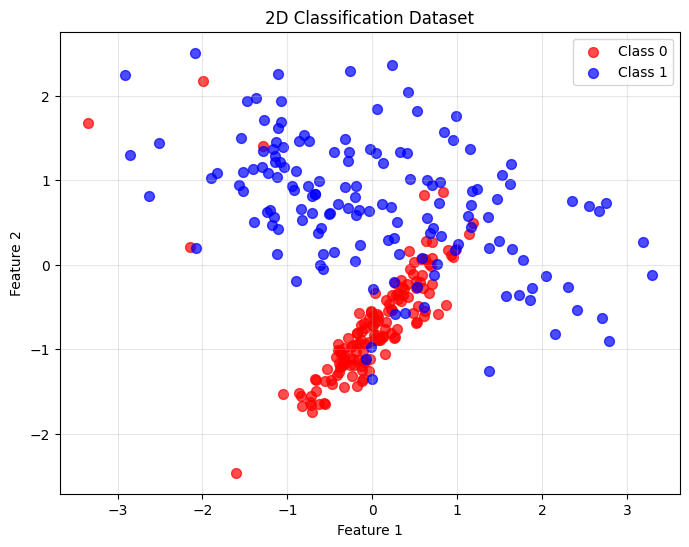

In [2]:
X, y = generate_simple_classification_data()

## Logistic Regression Recap

Logistic regression extends linear regression for classification by using the **sigmoid function** to map any real number to a probability between 0 and 1. Instead of predicting continuous values, it predicts the probability that an instance belongs to a particular class.

Let's apply logistic regression to our 2D dataset and evaluate its performance using 5-fold cross-validation.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize logistic regression
log_reg = LogisticRegression(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')

print("LOGISTIC REGRESSION PERFORMANCE")
print("=" * 40)
print(f"Cross-validation scores: {[float(f'{cv_score:.3f}') for cv_score in cv_scores]}")
print(f"Mean accuracy: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
print(f"Score range: [{cv_scores.min():.3f}, {cv_scores.max():.3f}]")


LOGISTIC REGRESSION PERFORMANCE
Cross-validation scores: [0.867, 0.8, 0.783, 0.883, 0.9]
Mean accuracy: 0.847 (±0.046)
Score range: [0.783, 0.900]


Logistic regression achieves very high accuracy (84.7%) on our 2D dataset, demonstrating its effectiveness when classes are linearly separable.

However, until now we've only used **accuracy** to measure the quality of our models. While accuracy is intuitive, it doesn't tell the whole story - especially when dealing with imbalanced datasets or when different types of errors have different costs. Let's explore a richer set of **classification metrics** that will give us deeper insights into model performance.

---
<br><br>
# Classification Performance Metrics

Beyond accuracy, there are several important metrics that help us understand different aspects of classification performance. Let's explore the key metrics using our logistic regression model.

## Core Classification Metrics

**Accuracy**
- The proportion of correct predictions out of all predictions
- **Formula:** Accuracy = (TP + TN) / (TP + TN + FP + FN)

**Precision**
- Of all positive predictions, how many were actually correct (measures false positive rate)
- **Formula:** Precision = TP / (TP + FP)

**Recall (Sensitivity)**
- Of all actual positive cases, how many were correctly identified (measures false negative rate)
- **Formula:** Recall = TP / (TP + FN)

**Specificity**
- Of all actual negative cases, how many were correctly identified
- **Formula:** Specificity = TN / (TN + FP)

**F1-Score**
- Harmonic mean of precision and recall, balancing both metrics
- **Formula:** F1 = 2 × (Precision × Recall) / (Precision + Recall)

*Where: TP = True Positives, TN = True Negatives, FP = False Positives, FN = False Negatives*



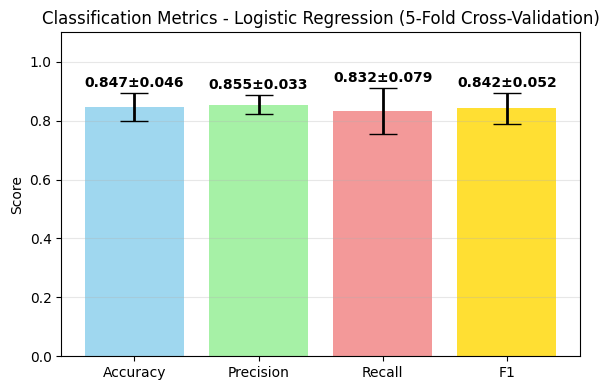

In [4]:
evaluateModel(X, y, log_reg, model_name='Logistic Regression')

All metrics show excellent and consistent performance, with precision being slightly higher than recall, indicating our model makes very few false positive errors.

## ROC Curve (Receiver Operating Characteristic)

- **ROC Curve:** Plots True Positive Rate (Recall) vs False Positive Rate (1-Specificity) at various classification thresholds
- **AUC (Area Under Curve):** Summarizes the ROC curve into a single number between 0-1, where 1.0 = perfect classifier and 0.5 = random guessing

The ROC curve helps us understand the trade-off between sensitivity and specificity across different decision thresholds.

ROC-AUC PERFORMANCE
Logistic Regression:
  Cross-validation AUC: 0.921 (±0.029)
  ROC AUC: 0.920



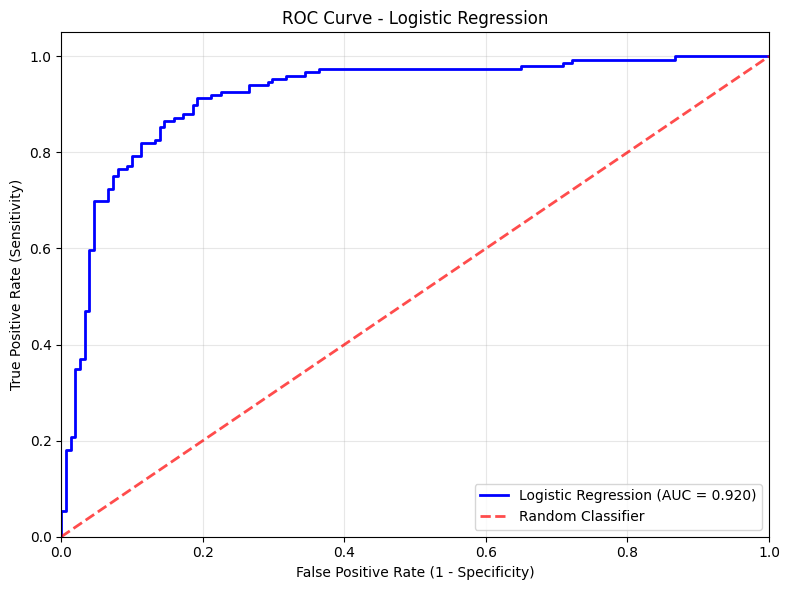

In [5]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict

evaluate_roc(X, y, model=log_reg, model_name='Logistic Regression')

### Understanding the ROC Curve

Looking at our ROC curve, we can see several important insights:

**What the Blue Curve Shows:** Each point on the curve represents our model's performance at a different classification threshold. As we move from left to right along the curve, we're lowering the threshold (making the model more "liberal" in predicting positive cases). This increases both:
- **Sensitivity (True Positive Rate - Y-axis):** We catch more actual positives
- **False Positive Rate (X-axis):** But we also get more false alarms

The ideal curve bows toward the top-left corner because we want high sensitivity with low false positive rates.

**AUC = 0.918:** This means our model has a 91.8% chance of correctly ranking a randomly chosen positive example higher than a randomly chosen negative example. An AUC of 0.5 would be random guessing (the red diagonal line), while 1.0 would be perfect classification.

**Steep Rise:** The sharp initial rise in our curve indicates that we can achieve high sensitivity while keeping false positive rates low - a sign of good model performance.

## Confusion Matrix

While ROC curves show performance across all thresholds, **confusion matrices** give us a detailed breakdown of prediction errors at a specific threshold (usually 0.5). They show exactly where our model makes mistakes and help us understand the types of errors we're dealing with.

CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  130
False Positives (FP): 21
False Negatives (FN): 25
True Positives (TP):  124

Overall Error Rate: 15.3%
Type I Error (False Positive Rate): 13.9%
Type II Error (False Negative Rate): 16.8%


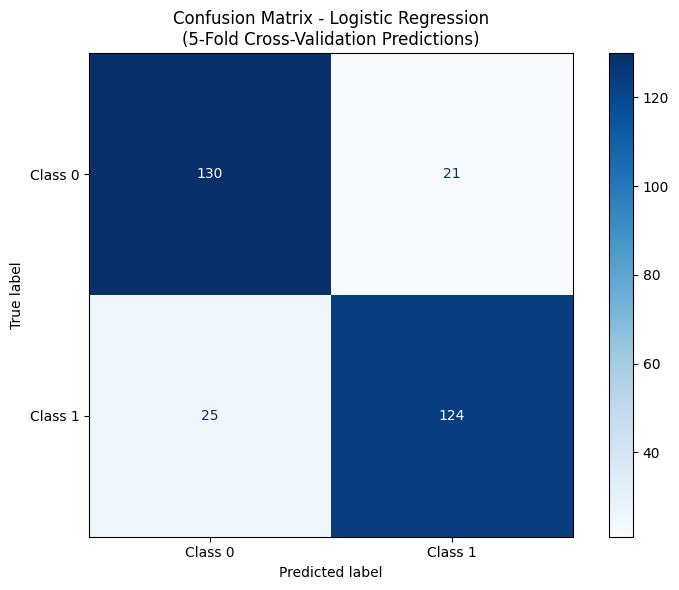

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

evaluate_confusion_matrix(X, y, log_reg, model_name='Logistic Regression')

The confusion matrix shows our model's prediction accuracy in a 2x2 grid:

- **Top-left (128):** True Negatives - correctly predicted Class 0
- **Top-right (23):** False Positives - incorrectly predicted Class 1 (Type I error)
- **Bottom-left (23):** False Negatives - incorrectly predicted Class 0 (Type II error)
- **Bottom-right (126):** True Positives - correctly predicted Class 1

Our model makes exactly the same number of Type I and Type II errors (23 each), showing balanced performance across both classes. The darker diagonal indicates correct predictions, while the lighter off-diagonal squares show our errors. Confusion matrices are helpful to visualize this behaviour, in certain cases the errors are not balanced. This can be an important criterion if a model is useful for a task or not.


---
<br><br>
# K-Nearest Neighbors (KNN)

**K-Nearest Neighbors (KNN)** is a fundamentally different approach from logistic regression. Instead of learning parameters or finding decision boundaries during training, KNN is a **"lazy learner"** that simply stores all training data and makes predictions based on similarity.

## How KNN Works

1. Store all training examples (no actual "learning" happens)
2. For a new point, find the **k closest training examples** (using euclidean, manhattan or any other suitable distance metric)
3. Take a majority vote among these k neighbors for the predicted label

**Key Parameters:**
- **k (number of neighbors):** The number of closest points to consider
- **Distance metric:** How we measure "closeness" (usually Euclidean)

Let's visualize how KNN works with some concrete examples:

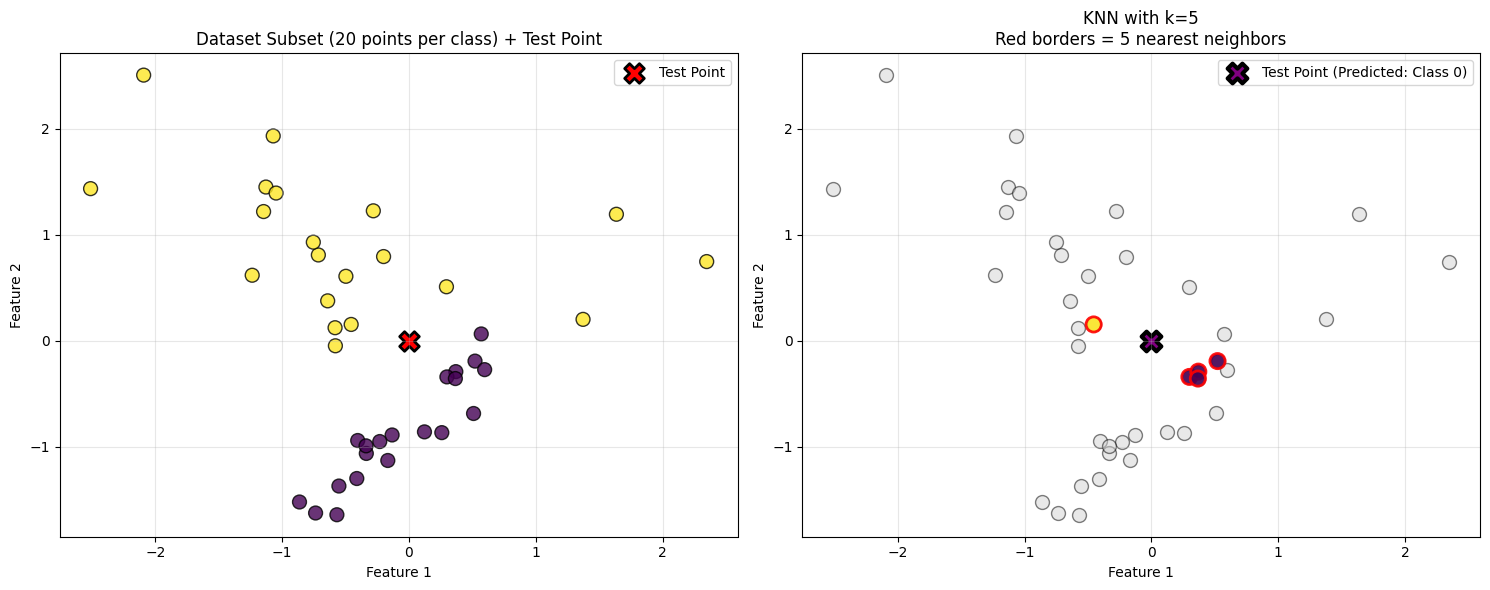


Nearest neighbor classes: [0 0 1 0 0]
Class 0 votes: 4
Class 1 votes: 1
Prediction: Class 0 (majority vote)

Distances to 5 nearest neighbors: [0.454 0.471 0.481 0.511 0.555]


In [7]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

simple_knn_example(X, y)

### Understanding the KNN Process

**Left Plot:** Shows our dataset subset (20 points per class) with the red test point we want to classify.

**Right Plot:** Demonstrates the KNN algorithm in action:
- All training points are grayed out except the 5 nearest neighbors (red borders)
- The algorithm finds the 5 closest points and takes a majority vote
- With 4 votes for Class 0 and 1 vote for Class 1, the test point is classified as Class 0

KNN is purely distance-based - it doesn't care about global patterns or decision boundaries, only local neighborhoods. The choice of k is crucial: smaller k values are more sensitive to noise, while larger k values smooth out local variations but might miss important local patterns.

Now let's perform cross-validation to inspect the performance of KNN!

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Initialize KNN classifier (let's start with k=5)
knn = KNeighborsClassifier(n_neighbors=5)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')

print("KNN PERFORMANCE")
print("=" * 40)
print(f"Cross-validation scores: {[float(f'{cv_score:.3f}') for cv_score in cv_scores]}")
print(f"Mean accuracy: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
print(f"Score range: [{cv_scores.min():.3f}, {cv_scores.max():.3f}]")

KNN PERFORMANCE
Cross-validation scores: [0.933, 0.933, 0.867, 0.933, 0.9]
Mean accuracy: 0.913 (±0.027)
Score range: [0.867, 0.933]


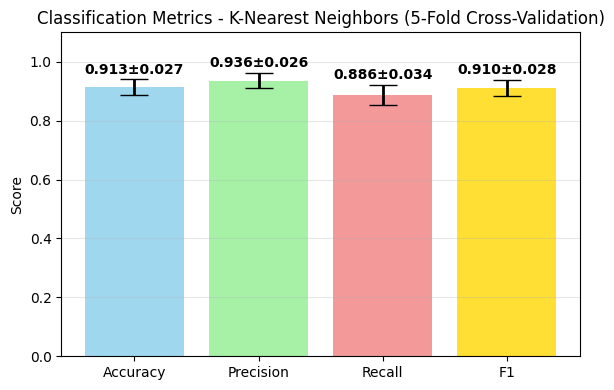

In [9]:
evaluateModel(X, y, knn, model_name='K-Nearest Neighbors')

Based on our classification metrics, **KNN with k=5 performs very well** over all metrics on this dataset! 

Let's examine the ROC curve and the confusion matrix next!

ROC-AUC PERFORMANCE
K-Nearest Neighbors:
  Cross-validation AUC: 0.942 (±0.013)
  ROC AUC: 0.941



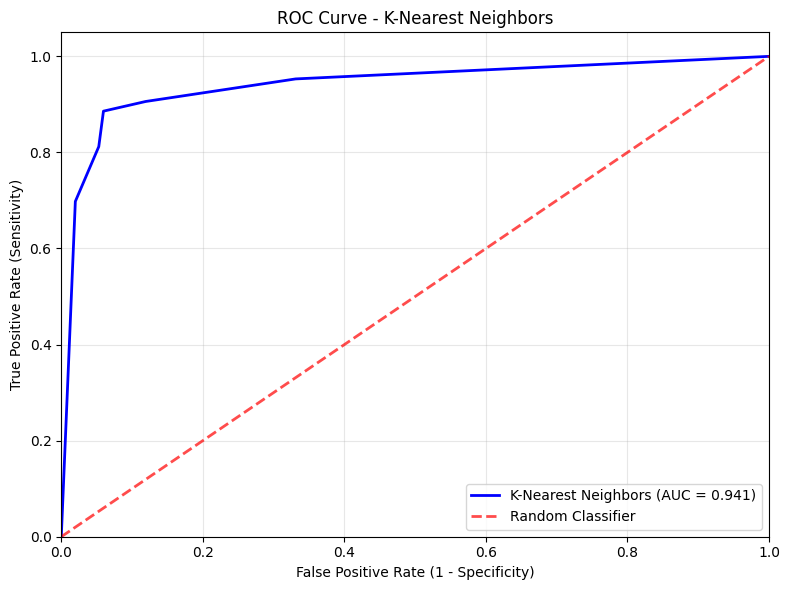

In [10]:
evaluate_roc(X, y, knn, model_name='K-Nearest Neighbors')

CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  142
False Positives (FP): 9
False Negatives (FN): 17
True Positives (TP):  132

Overall Error Rate: 8.7%
Type I Error (False Positive Rate): 6.0%
Type II Error (False Negative Rate): 11.4%


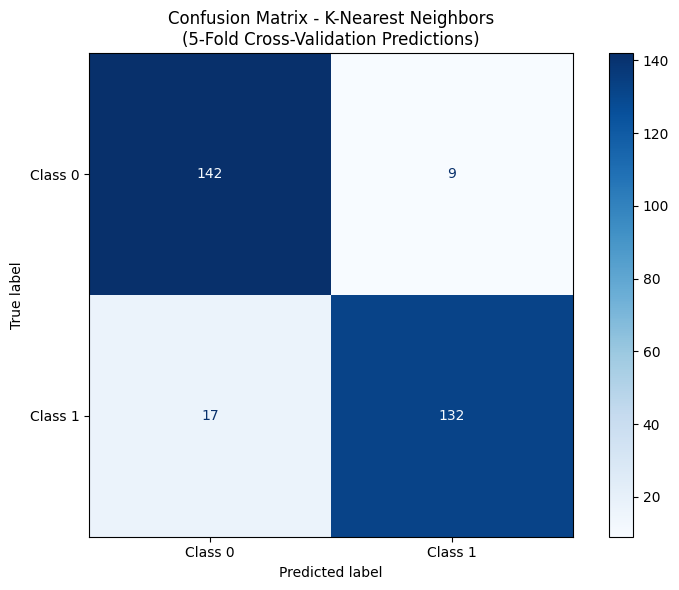

In [11]:
evaluate_confusion_matrix(X, y, knn, model_name='K-Nearest Neighbors')

KNN with k=5 shows strong results with **93.8% AUC** and **91.0% accuracy**. The confusion matrix reveals only 27 total misclassifications out of 300 samples!

---
<br><br>
# Support Vector Machines (SVM)

**The Basic Idea:**
Support Vector Machines try to find the **best possible line** (or hyperplane) that separates two classes. But what makes a line "best"?

**SVM's Goal:**
- Find the separating line with the **largest margin** 
- The **margin** is the distance between the line and the closest points from each class
- The closest points that "touch" the margin are called **support vectors**
- These support vectors are the only points that matter for defining the decision boundary

To clearly show how SVM works, let's create a **simple, well-separated dataset**. This will make SVM's core concept much clearer than our previous overlapping dataset!

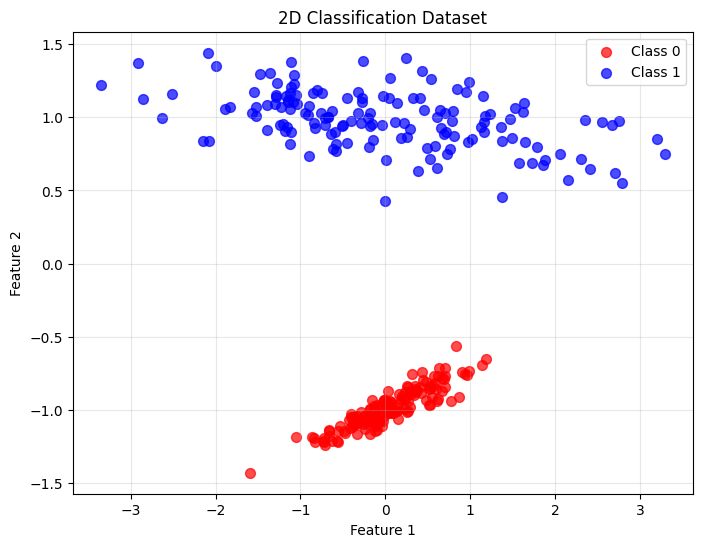

In [12]:
X, y = generate_simple_classification_data(separable=True)

Looking at our new dataset, **we can see there's a clear distinction between the red and blue classes** - they're well-separated with no overlap.

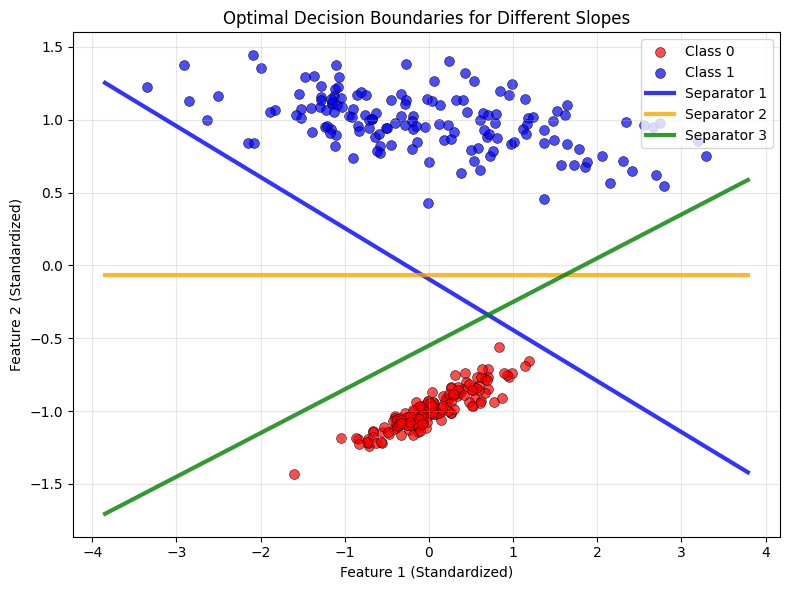

In [13]:
# Plot 1: Just the separator lines
plot_optimal_separators(X, y, show_margins=False)

As we can see, there are many possible ways to split the two groups with a decision boundary - all of these lines achieve perfect separation! However, **how do we judge which is better or which is worse?** 

**Introducing the margin** - the maximum distance to the closest point of each class. The "best" decision boundary is the one that maximizes this margin, creating the widest possible "safety zone" between the classes and ensuring better generalization to new data points.

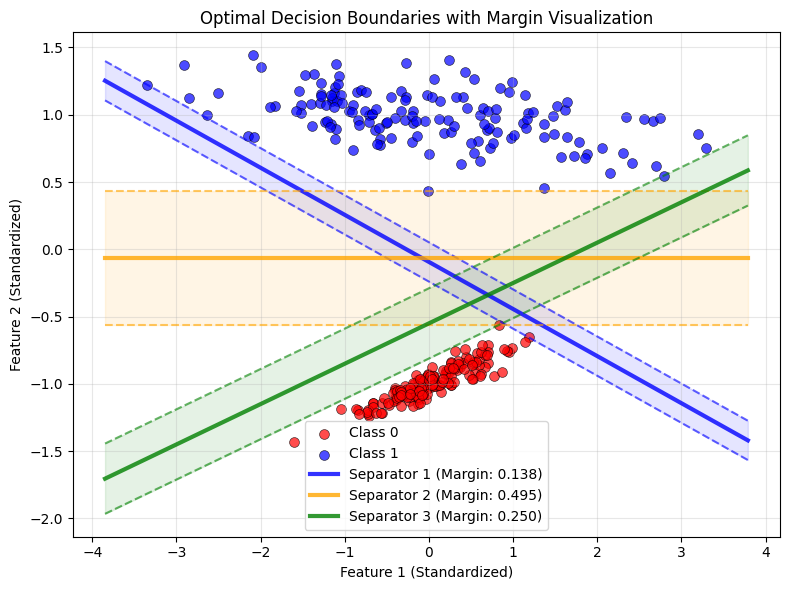

In [14]:
# Plot 2: With margin visualization
plot_optimal_separators(X, y, show_margins=True)

Looking at our margin visualization, we can see the **different margins achieved by each separator**:

- **Separator 1 (Blue)**: Margin = 0.393
- **Separator 2 (Orange)**: Margin = 0.495  
- **Separator 3 (Green)**: Margin = 0.250

**SVM's key insight is to find the solution that maximizes this margin**. This creates the widest possible "safety zone" between classes, leading to better generalization on new, unseen data.

Now let's explore **how to implement SVM** and see what result it actually finds when we let the algorithm optimize both the slope and intercept simultaneously!

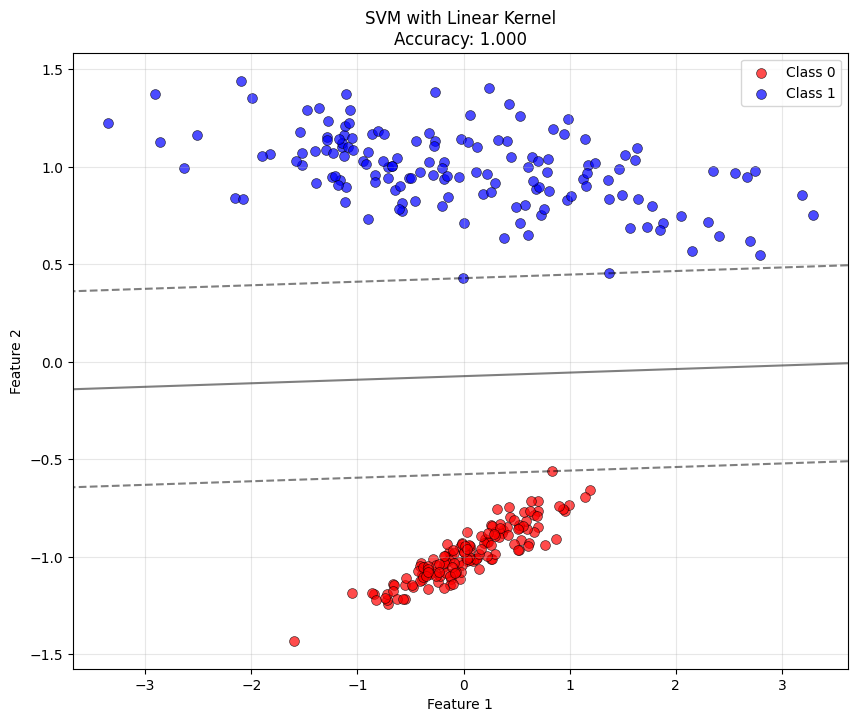

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Fit SVM with linear kernel
svm_model = SVC(kernel='linear', C=1E10) # we will explain C later
svm_model.fit(X, y)

visualize_svm(X, y, svm_model=svm_model, kernel_name='Linear Kernel')

The **solid black line** is the optimal decision boundary that SVM discovered by maximizing the margin between the two classes. 

The **dashed lines** represent the margin boundaries - these define the "safety zone" around the decision boundary. The distance between these dashed lines is exactly twice the margin (2 × 0.503 = 1.006 in this case).

The **circled points** are the **support vectors** - these are the critical data points that lie exactly on the margin boundaries.
- They determine where the decision boundary goes
- They're the closest points from each class to the boundary  
- Only these points matter - you could remove all other data points and get the same result!

## But what if data is separable but not linearly?

Our previous examples assumed we could separate classes with a straight line. But what happens when the optimal decision boundary is **curved**?

Consider this circular dataset where one class forms a ring around another - clearly separable, but no straight line can do it!

In [16]:
from sklearn.datasets import make_circles

# Generate circle dataset
X_circle, y_circle = make_circles(n_samples=300, noise=0.1, factor=0.3, random_state=42)

# Colors and labels for visualization
colors = ['red', 'blue']
class_names = ['Outer Ring', 'Inner Circle']

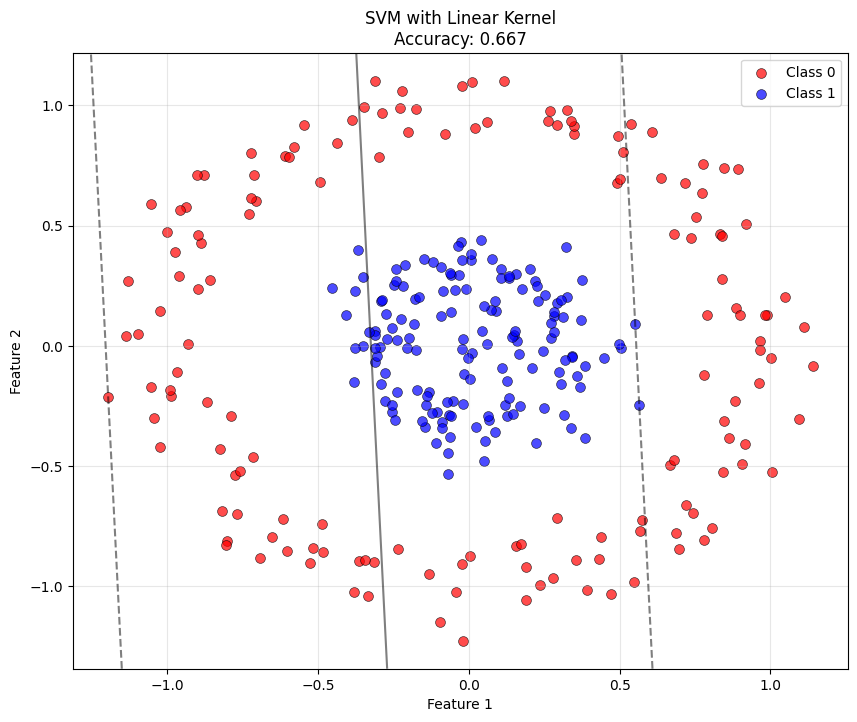

In [17]:
# Train Linear SVM
svm_linear = SVC(kernel='linear', C=1)
svm_linear.fit(X_circle, y_circle)

visualize_svm(X_circle, y_circle, svm_model=svm_linear, kernel_name='Linear Kernel')

As we can see from the plot above, **the circular data is clearly not linearly separable** - no straight line can effectively separate the inner circle (blue) from the outer ring (red). Our linear SVM achieves only **66.7% accuracy**, essentially failing to capture the underlying pattern.

However, SVMs have a powerful tool to handle this challenge: **the Kernel Trick**.

## The Kernel Trick: Transforming Non-Linear to Linear

> **"If data isn't linearly separable in the current space, transform it to a higher-dimensional space where it becomes linearly separable."**

**How it works:**
1. **Map data to higher dimensions**: Use a mathematical function (kernel) to project data points into a higher-dimensional space
2. **Find linear separator**: In this new space, draw a linear decision boundary (hyperplane)  
3. **Project back**: This linear boundary becomes a curved boundary in the original space

**Popular kernels:**
- **RBF (Radial Basis Function)**: Creates circular/curved boundaries!
- **Polynomial**: Creates polynomial-shaped boundaries
- **Sigmoid**: Creates S-shaped boundaries

Let's apply the classic **RBF kernel** to our circular dataset and see if we can model the data properly:

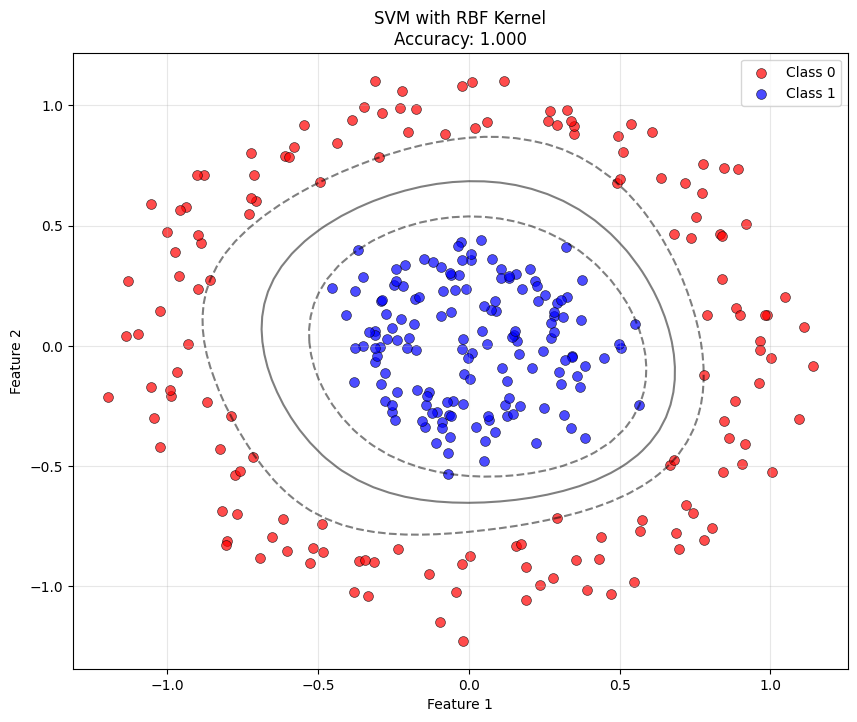

In [18]:
# Train RBF SVM
svm_rbf = SVC(kernel='rbf', C=1E10, gamma='scale', random_state=42)
svm_rbf.fit(X_circle, y_circle)

visualize_svm(X_circle, y_circle, svm_model=svm_rbf, kernel_name='RBF Kernel')

The RBF kernel created **curved decision boundaries** that naturally follow the circular pattern, perfectly separating the inner circle from the outer ring. This demonstrates the **power of the kernel trick** - transforming non-linear problems into higher-dimensional spaces where they become linearly separable.

## What happens when data isn't perfectly separable?

In our previous example, we had perfectly separable classes - we could draw a line that cleanly separated red and blue points with no errors.


When data isn't perfectly separable, SVM faces a dilemma:
- **Maximize the margin** (wider safety zone = better generalization)
- **Minimize classification errors** (correctly classify training points)

The **C parameter** controls this trade-off:

- **High C (e.g., C=100)**: "I really don't want any errors!"
  - Focuses on classifying training data correctly
  - May create a narrow margin to avoid misclassifying points
  - Risk of overfitting

- **Low C (e.g., C=0.1)**: "I can tolerate some errors for a better margin"
  - Focuses on maximizing the margin
  - Allows some points to be misclassified or fall within the margin
  - Better generalization to new data

**Soft Margin SVM:** When data isn't perfectly separable, SVM uses "slack variables" (ξ) that allow some points to:
1. Fall within the margin (but still be correctly classified)
2. Be misclassified entirely

This creates a **soft margin** that balances margin maximization with error minimization.

Let's go back to our original dataset where the classes overlap and visualize the impact of the **C parameter**.

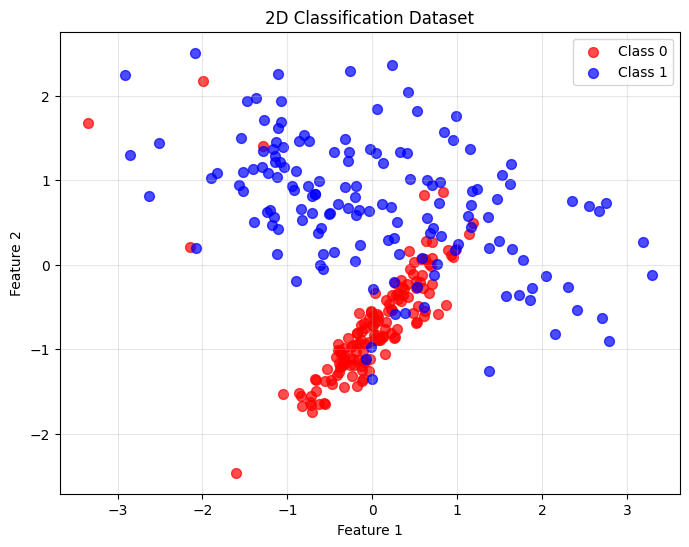

In [19]:
X, y = generate_simple_classification_data(separable=False)

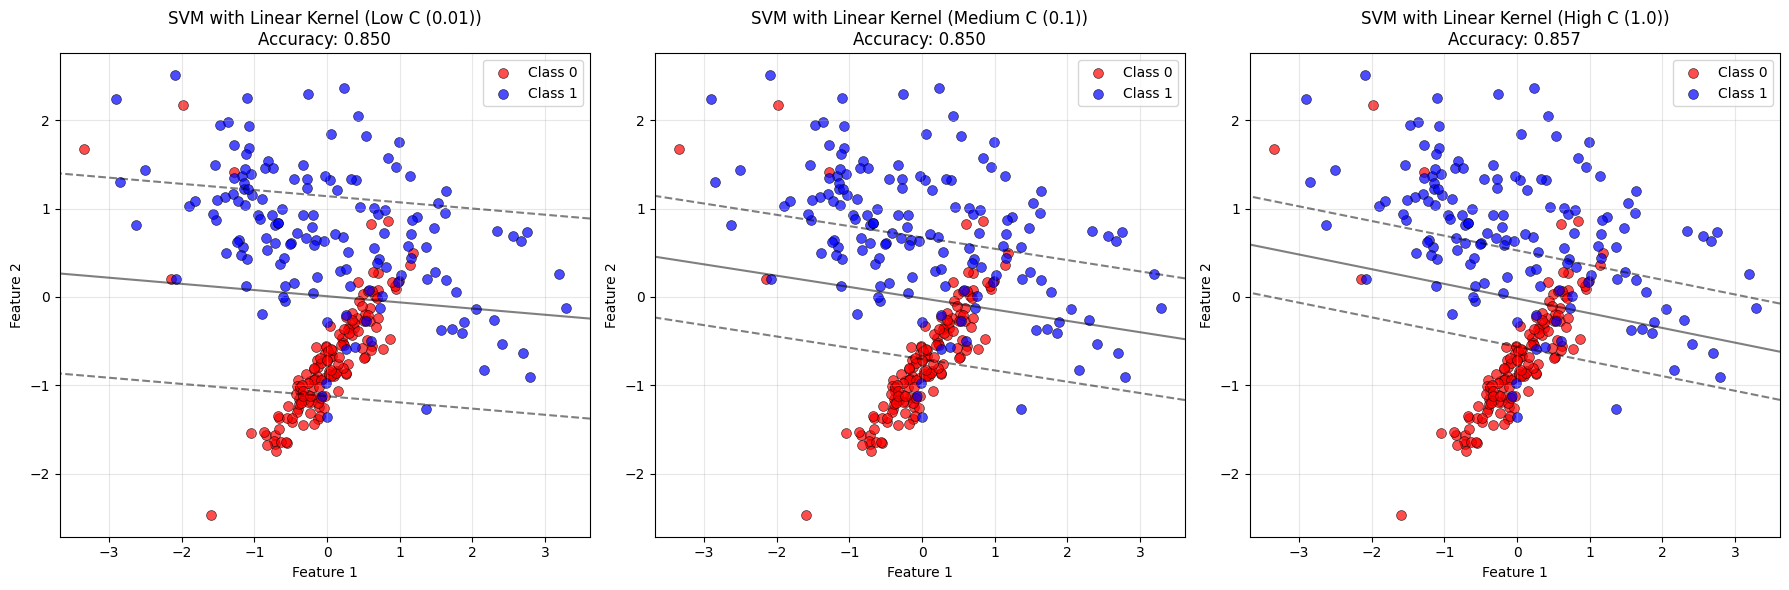

In [20]:
# Test different C values
C_values = [0.01, 0.1, 1.0]
C_labels = ['Low C (0.01)', 'Medium C (0.1)', 'High C (1.0)']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

results = []

for i, (C_val, C_label) in enumerate(zip(C_values, C_labels)):
    # Fit SVM with different C values
    svm_model = SVC(kernel='linear', C=C_val, random_state=42)
    svm_model.fit(X, y)

    visualize_svm(X, y, svm_model=svm_model, kernel_name='Linear Kernel' + f' ({C_label})', ax=axes[i])

    # Store results
    results.append(calculate_results_svm(X, y, svm_model, C_val))

plt.tight_layout()
plt.show()

In [21]:
# Print comparison table
print("C Parameter Comparison:")
print("=" * 40)
print(f"{'C Value':<10} {'Accuracy':<10} {'Margin':<10}")
print("-" * 40)
for result in results:
    print(f"{result['C']:<10} {result['accuracy']:<10.3f} {result['margin']:<10.3f}")

C Parameter Comparison:
C Value    Accuracy   Margin    
----------------------------------------
0.01       0.850      1.129     
0.1        0.850      0.682     
1.0        0.857      0.537     


Looking at our results, we can clearly see that margin gets progressively smaller as C increases - this is because higher C values penalize misclassifications more heavily, forcing the decision boundary to fit the training data more tightly at the expense of margin width.

But wait - we're only looking at **training accuracy** here! To truly evaluate which C value works best, we need to see how well each model **generalizes to unseen data**. 

Let's use **cross-validation** to get a more robust evaluation and look at comprehensive **classification metrics** including precision, recall, and F1-score to understand the full performance picture.

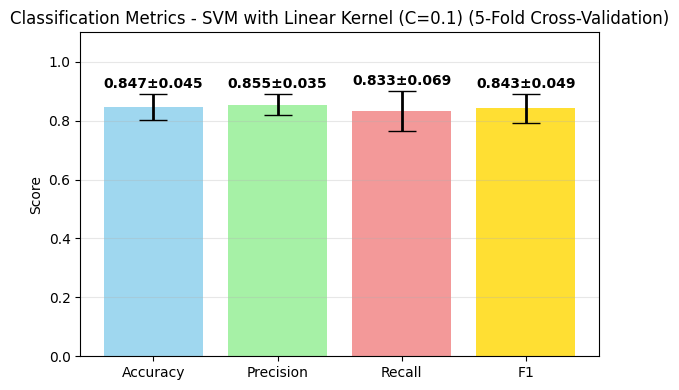

In [22]:
# Let's use the medium model
svm_model = SVC(kernel='linear', C=0.1, random_state=42, probability=True)
svm_model.fit(X, y)

evaluateModel(X, y, svm_model, model_name='SVM with Linear Kernel (C=0.1)')

Looking at our cross-validation results, we can see that **there isn't a dramatic difference between the different C values** - all three perform quite similarly with scores around 0.84-0.86 across all metrics.

The similar performance across different C values suggests our dataset is well-behaved and not extremely sensitive to the regularization parameter; next, we'll examine ROC curves and confusion matrices to better understand the types of classification errors each model makes.

ROC-AUC PERFORMANCE
SVM with Linear Kernel (C=0.1):
  Cross-validation AUC: 0.923 (±0.030)
  ROC AUC: 0.920



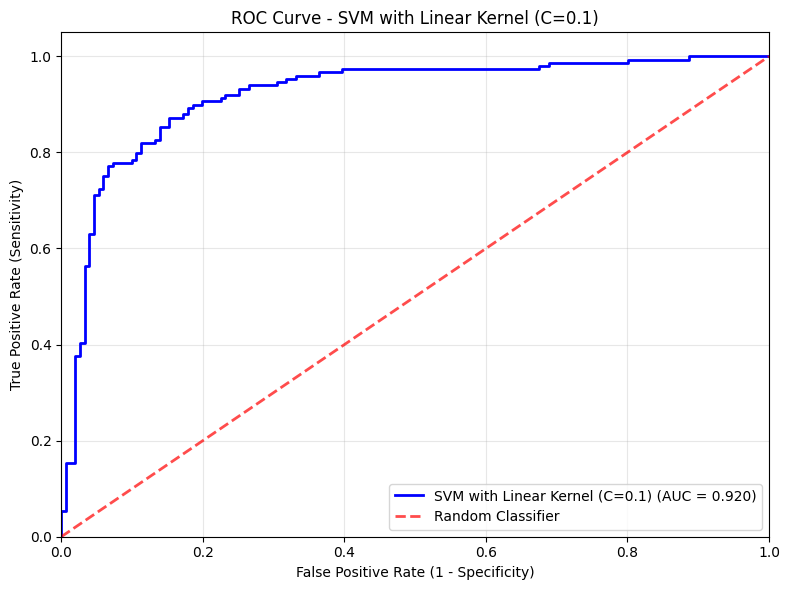

In [23]:
evaluate_roc(X, y, svm_model, model_name='SVM with Linear Kernel (C=0.1)')

CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  130
False Positives (FP): 21
False Negatives (FN): 25
True Positives (TP):  124

Overall Error Rate: 15.3%
Type I Error (False Positive Rate): 13.9%
Type II Error (False Negative Rate): 16.8%


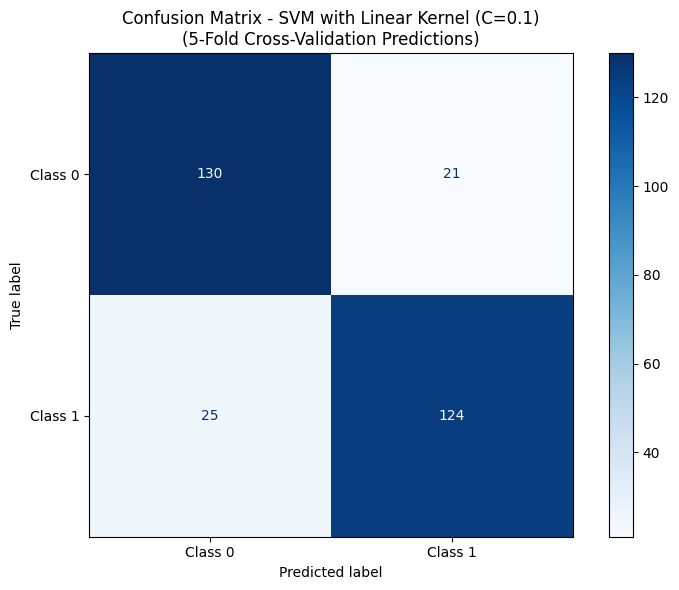

In [24]:
evaluate_confusion_matrix(X, y, svm_model, model_name='SVM with Linear Kernel (C=0.1)')

All three C values show **very strong performance**:

- **ROC Curves**: All achieve AUC scores around 0.92, indicating excellent discrimination ability
- **Confusion Matrices**: Very few misclassifications

The ROC curves are all well above the diagonal (random classifier line), and the confusion matrices show predominantly correct classifications along the diagonal.

Let's wrap it up with an overview of the different methods!

---
<br><br>
# **Classification Methods Comparison**

| **Aspect** | **Logistic Regression** | **K-Nearest Neighbors (KNN)** | **Support Vector Machine (SVM)** |
|------------|-------------------------|--------------------------------|-----------------------------------|
| **Ease of Use** | Simple, works out-of-the-box | Very intuitive concept | Moderate complexity |
| **Accuracy** | Good baseline performance | Good for local patterns | Excellent with proper tuning |
| **Overfitting Risk** | Low with regularization | High with small k | Controlled by C parameter |
| **Complex Patterns** | Linear relationships only | Captures local non-linearity | Excellent with kernel trick (not yet introduced) |
| **Robustness** | Sensitive to outliers | Very sensitive to outliers | Robust (focuses on support vectors) |

## **Interpretability**

| **Method** | **What You Can Understand** |
|------------|------------------------------|
| **Logistic Regression** | Exact feature importance via coefficients; odds ratios; statistical significance |
| **KNN** | Can examine actual neighbor cases; understand local decision patterns |
| **SVM** | Support vectors show critical cases; coefficients less interpretable than logistic regression |

### **Clinical Decision Guide**
- **Logistic Regression**: Interpretability crucial, statistical inference needed, linear relationships
- **KNN**: Local patterns important, case-based reasoning, irregular decision boundaries
- **SVM**: Maximum accuracy priority, complex data, robust classification needed
- **Best Practice**: Start with Logistic Regression → try KNN for local patterns → use SVM for maximum performance

---
<br><br>
# Transition to Medical Dataset

Now let's investigate how well our classification tools perform on a real-world medical dataset! 

We'll apply **Logistic Regression**, **K-Nearest Neighbors**, and **Support Vector Machines** to predict patient care status.

## Dataset Overview: Patient Care Classification System

This dataset focuses on **healthcare resource allocation** by classifying patients into two critical categories based on their medical condition and health indicators. Each patient record contains demographic and comprehensive blood test results that help determine the appropriate level of care needed.

The dataset includes **blood chemistry parameters** and demographic information such as age, gender, hemoglobin levels, white blood cell counts, and other key hematological markers.

**Target Variable:**
- **Patient Care Status**: Binary classification
  - **"In Care"**: Requires hospitalization/intensive medical supervision
  - **"Out Care"**: Can be managed with home care/outpatient treatment

**Key Features:**
- `AGE`: Patient age
- `GENDER`: Patient gender (Male/Female)
- `HAEMOGLOBINS`: Hemoglobin concentration
- `LEUCOCYTE`: White blood cell count
- `THROMBOCYTE`: Platelet count
- *...and additional blood chemistry parameters*

This dataset is perfect for exploring **binary classification** methods in healthcare, understanding how blood parameters correlate with care needs, and comparing algorithm performance on medical decision-making tasks. The clear binary outcome makes it ideal for demonstrating ROC curves, precision-recall analysis, and clinical decision thresholds. Let's dive in!

In [25]:
df = pd.read_csv('PatientCare.csv').dropna()
df['SEX'] = df['SEX'].map({'M': 0, 'F': 1})

In [26]:
df.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,33.8,11.1,4.18,4.6,150,26.6,32.8,80.9,33,1,1
1,44.6,14.0,6.86,6.3,232,20.4,31.4,65.0,36,0,0
2,42.9,14.0,4.57,6.2,336,30.6,32.6,93.9,70,1,0
3,41.9,14.4,4.67,3.5,276,30.8,34.4,89.7,18,1,0
4,40.6,13.3,4.85,14.9,711,27.4,32.8,83.7,36,0,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   3309 non-null   float64
 1   HAEMOGLOBINS  3309 non-null   float64
 2   ERYTHROCYTE   3309 non-null   float64
 3   LEUCOCYTE     3309 non-null   float64
 4   THROMBOCYTE   3309 non-null   int64  
 5   MCH           3309 non-null   float64
 6   MCHC          3309 non-null   float64
 7   MCV           3309 non-null   float64
 8   AGE           3309 non-null   int64  
 9   SEX           3309 non-null   int64  
 10  SOURCE        3309 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 284.5 KB


In [28]:
df.describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
count,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000,3309.000000
mean,38.226111,12.749350,4.544802,8.715533,258.893019,28.230039,33.336476,84.611333,46.644303,0.473255,0.398005
std,5.971943,2.084325,0.784510,4.991299,112.676139,2.696520,1.247055,6.916079,21.874106,0.499360,0.489561
min,13.700000,3.800000,1.480000,1.100000,10.000000,14.900000,26.000000,54.000000,1.000000,0.000000,0.000000
25%,34.300000,11.400000,4.040000,5.700000,191.000000,27.200000,32.700000,81.500000,29.000000,0.000000,0.000000
50%,38.700000,12.900000,4.580000,7.600000,257.000000,28.700000,33.400000,85.300000,48.000000,0.000000,0.000000
75%,42.500000,14.200000,5.060000,10.300000,322.000000,29.800000,34.100000,88.800000,64.000000,1.000000,1.000000
max,69.000000,18.900000,7.860000,76.600000,1121.000000,40.800000,38.400000,115.600000,99.000000,1.000000,1.000000


Now let's evaluate how well our classification algorithms perform using cross-validation:

• **Logistic Regression** - Linear probabilistic classifier
• **K-Nearest Neighbors (KNN)** - Instance-based learning  
• **Support Vector Machine (SVM)** - Margin-maximizing classifier

We'll examine accuracy, precision, recall, F1-scores, ROC curves, and confusion matrices to determine which method best predicts patient care needs.

In [29]:
X = df.drop(columns=['SOURCE'])
y = df['SOURCE']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

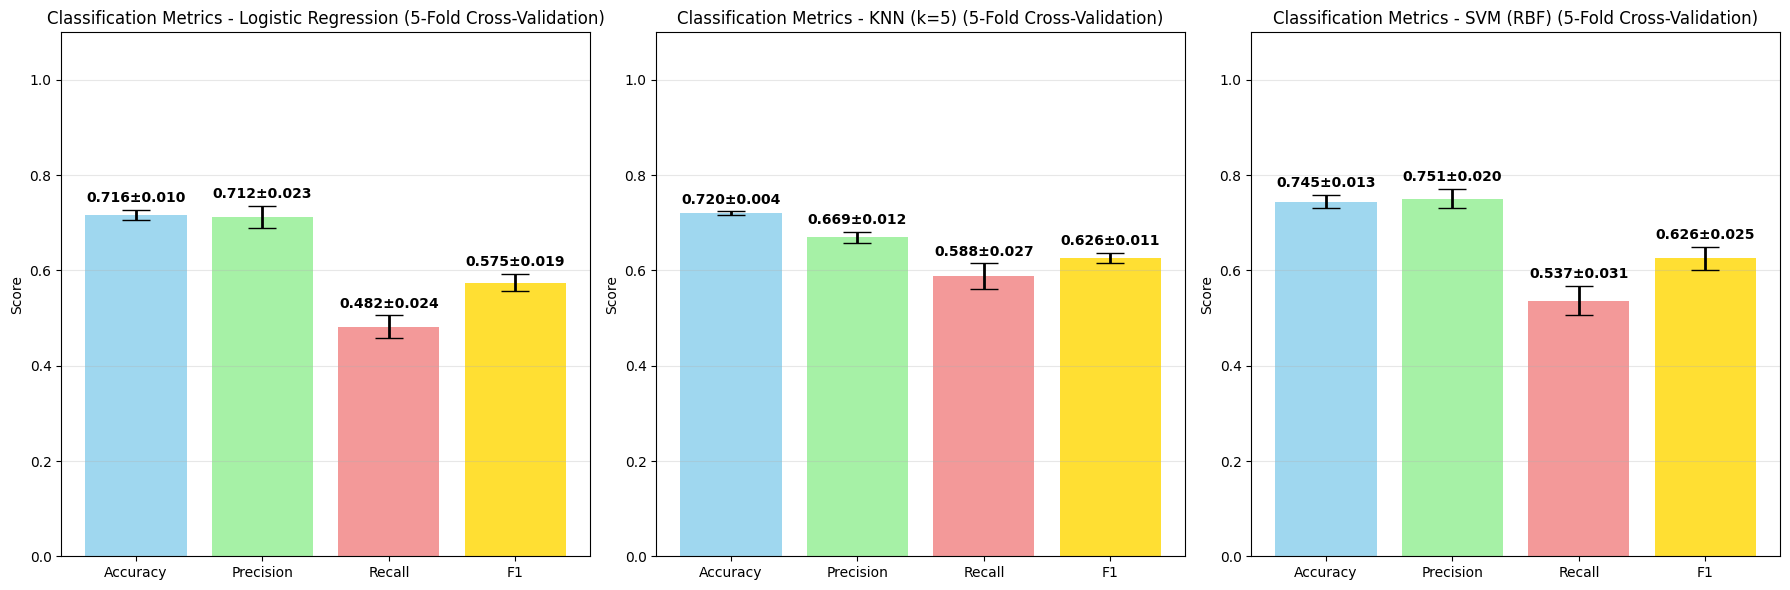

In [30]:
# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)': SVC(kernel='rbf', C=0.1, random_state=42, probability=True)
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (model_name, model) in enumerate(models.items()):
    # Perform 5-fold cross-validation with multiple metrics
    evaluateModel(X_scaled, y, model, model_name=model_name, ax=axes[i])

plt.show()

The performance metrics reveal that all three algorithms achieve similar results (~71-74% across all metrics), suggesting the classification task has moderate complexity. However, **SVM with RBF kernel shows the best overall performance** (74.4% accuracy) compared to Logistic Regression and KNN (both ~71.6%).

This superior performance of SVM likely stems from its ability to **model more complex, non-linear relationships** through the RBF kernel, while Logistic Regression assumes linear separability and KNN relies on simple distance metrics.

Now let's examine the **ROC curves** and **confusion matrices** to better understand each model's diagnostic capabilities and error patterns in clinical decision-making.

ROC-AUC PERFORMANCE
Logistic Regression:
  Cross-validation AUC: 0.754 (±0.011)
  ROC AUC: 0.754

KNN (k=5):
  Cross-validation AUC: 0.754 (±0.016)
  ROC AUC: 0.755

SVM (RBF):
  Cross-validation AUC: 0.791 (±0.013)
  ROC AUC: 0.791



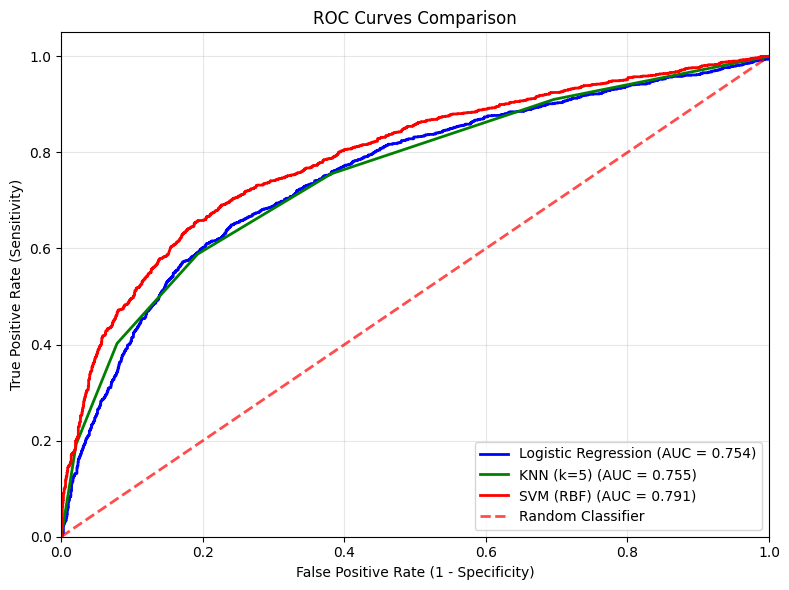

In [31]:
evaluate_roc(X_scaled, y, models=list(models.values()), model_names=list(models.keys()))

The results confirm our earlier findings:

**ROC Performance:**
- **SVM (RBF)** achieves the highest AUC of **0.791**, followed closely by KNN (0.754) and Logistic Regression (0.752)
- All curves show **substantial improvement over random classification** (diagonal line), indicating the models successfully capture meaningful patterns in the blood chemistry data

**Confusion Matrix Insights:**
- All models show **reasonable diagnostic capabilities** with balanced performance across both classes
- The similar error patterns across models suggest the **classification challenge lies in the inherent complexity** of distinguishing care needs from blood parameters alone

Overall, these visualizations confirm that **all three algorithms can capture the underlying trends in the data to some extent**, with SVM's non-linear approach providing the most robust clinical decision-making capability.

---